In [226]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import imgaug.augmenters as iaa
import time

from keras import layers
from keras.layers import Dropout
from keras.datasets import mnist
from keras.models import Model

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [227]:
def add_gaussian_noise(images):
    seq = iaa.AdditiveGaussianNoise(scale=(25, 35))
    augmented_images = seq.augment_images(images)
    return augmented_images

def display(*arrays):
    n = 10
    num_arrays = len(arrays)
    indices = np.random.randint(len(arrays[0]), size=n)
    
    fig, axes = plt.subplots(num_arrays, n, figsize=(20, 3 * num_arrays))
    for j, array in enumerate(arrays):
        sample = array[indices]
        for i, image in enumerate(sample):
            ax = axes[j, i]
            ax.imshow(image)
    plt.tight_layout()
    plt.show()

In [228]:
# Load the dataset
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()
print('Sample dims: ', train_images.shape)
print('Test samples: ', test_images.shape)

Sample dims:  (50000, 32, 32, 3)
Test samples:  (10000, 32, 32, 3)


In [229]:
#augmentation block
train_images_aug = []
train_labels_aug = []

augmentations = (
    iaa.Fliplr(1),
    iaa.Flipud(1),
    iaa.Affine(rotate=(-30))
)
  
#define amount of augmented images
num_augmented_samples = int(0.3 * len(train_images))

#Augmentation
for i in range(num_augmented_samples):
    random_aug = np.random.randint(0, 3)
    seq = iaa.Sequential(augmentations[random_aug])
    augmented_image = seq.augment_image(train_images[i])
    train_images_aug.append(np.expand_dims(augmented_image, axis=0))
    train_labels_aug.append(train_labels[i])


# fusion train and augmented
train_images_aug = np.concatenate(train_images_aug, axis=0)
train_labels_aug = np.array(train_labels_aug)
train_images = np.concatenate((train_images, train_images_aug))
train_labels = np.concatenate((train_labels, train_labels_aug))

print('Sample dims: ', train_images.shape)
print('Test samples: ', test_images.shape)

Sample dims:  (65000, 32, 32, 3)
Test samples:  (10000, 32, 32, 3)


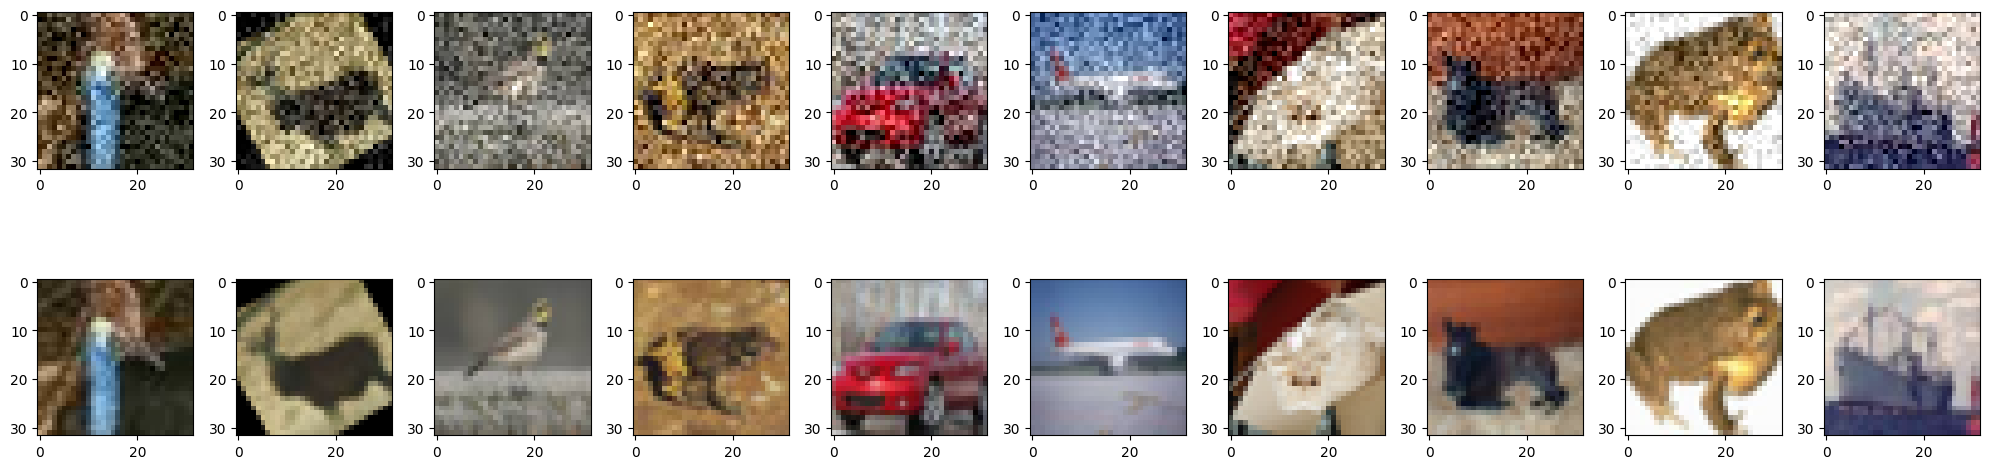

In [230]:

# Mapping from class ID to class name
classes = {0:'plane', 1:'car', 2:'bird', 3:'cat', 4:'deer',
           5:'dog', 6:'frog', 7:'horse', 8:'ship', 9:'truck'}

# Dataset params
num_classes = len(classes)
shape = train_images.shape

height = shape[1]
width = shape[2]

# Shuffle the training data (optional but recommended)
train_images, train_labels = shuffle(train_images, train_labels)

#Let's blur our images
noisy_train_data = add_gaussian_noise(train_images)
noisy_test_data = add_gaussian_noise(test_images)

#Show result
display(noisy_train_data, train_images)

In [231]:
train_images = np.array(train_images) / 255.0
test_images = np.array(test_images) / 255.0

input = layers.Input(shape=(32, 32, 3))

# Encoder
x = layers.Conv2D(8, (3, 3), activation="relu", padding="same")(input)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(16, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)

# Decoder
x = layers.Conv2DTranspose(16, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(16, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(3, (3, 3), activation="sigmoid", padding="same")(x)

# Autoencoder
autoencoder = Model(input, x)
autoencoder.compile(optimizer="adam", loss="MSE", metrics=["accuracy"])
autoencoder.summary()

Model: "functional_59"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_29 (InputLayer)     │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_87 (Conv2D)              │ (None, 32, 32, 8)      │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_58 (MaxPooling2D) │ (None, 16, 16, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_88 (Conv2D)              │ (None, 16, 16, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_59 (MaxPooling2D) │ (None, 8, 8, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_58             │ (None, 16, 16, 16)     │         2,320 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_59             │ (None, 32, 32, 16)     │         2,320 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_89 (Conv2D)              │ (None, 32, 32, 3)      │           435 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,467 (25.26 KB)

 Trainable params: 6,467 (25.26 KB)

 Non-trainable params: 0 (0.00 B)

In [232]:
epochs = 100
batch_size = 512
steps_per_epoch = len(noisy_train_data) // batch_size
history = autoencoder.fit(noisy_train_data, train_images,  batch_size=batch_size, epochs=epochs, validation_split=0.2)

Epoch 1/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - accuracy: 0.3652 - loss: 0.1103 - val_accuracy: 0.4361 - val_loss: 0.0258
Epoch 2/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - accuracy: 0.4807 - loss: 0.0226 - val_accuracy: 0.5583 - val_loss: 0.0170
Epoch 3/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - accuracy: 0.5734 - loss: 0.0160 - val_accuracy: 0.6040 - val_loss: 0.0135
Epoch 4/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - accuracy: 0.6121 - loss: 0.0131 - val_accuracy: 0.6243 - val_loss: 0.0118
Epoch 5/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - accuracy: 0.6280 - loss: 0.0115 - val_accuracy: 0.6365 - val_loss: 0.0105
Epoch 6/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - accuracy: 0.6405 - loss: 0.0104 - val_accuracy: 0.6484 - val_loss: 0.0097
Epoch 7/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - accuracy: 0.6521 - loss: 0.0096 - val_accuracy: 0.6539 - val_loss: 0.0092
Epoch 8/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - accuracy: 0.6604 - loss: 0.0090 - 

Train Acc      0.7829047441482544
Validation Acc 0.7841266989707947


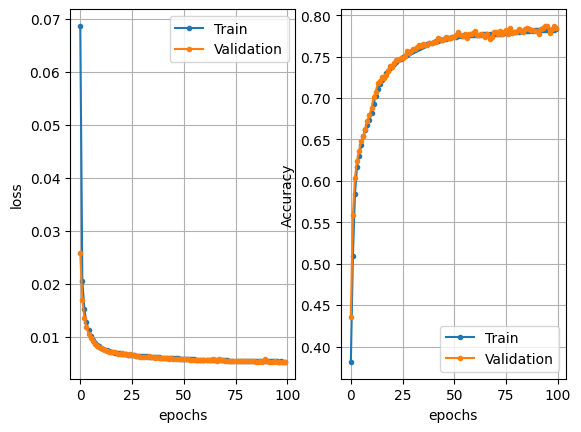

In [233]:
def plot_history(history):
    h = history.history
    epochs = range(len(h['loss']))

    plt.subplot(121), plt.plot(epochs, h['loss'], '.-', epochs, h['val_loss'], '.-')
    plt.grid(True), plt.xlabel('epochs'), plt.ylabel('loss')
    plt.legend(['Train', 'Validation'])
    plt.subplot(122), plt.plot(epochs, h['accuracy'], '.-',
                               epochs, h['val_accuracy'], '.-')
    plt.grid(True), plt.xlabel('epochs'), plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'])
        
    print('Train Acc     ', h['accuracy'][-1])
    print('Validation Acc', h['val_accuracy'][-1])
    
plot_history(history)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step


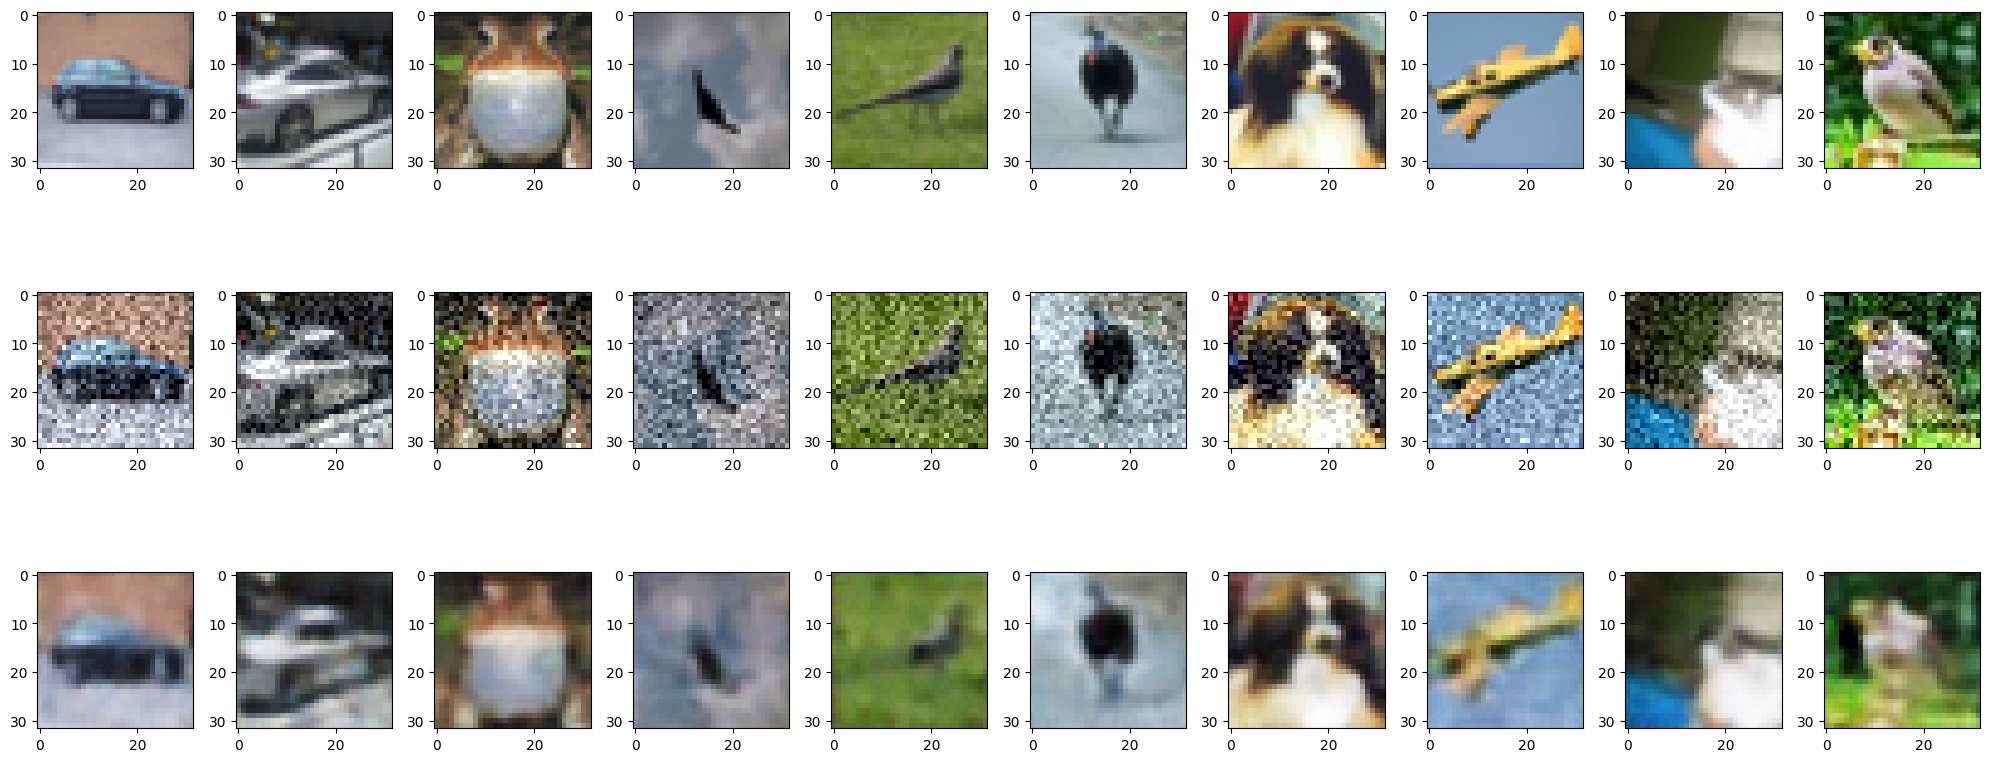

In [234]:
predictions = autoencoder.predict(noisy_test_data)
display(test_images, noisy_test_data, predictions)